In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# cnn model vary kernel size
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

from tensorflow.keras.utils import to_categorical
import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, Reshape, LSTM, Conv1D, MaxPooling1D, Bidirectional, ConvLSTM1D
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, MaxPooling1D, BatchNormalization, GlobalAveragePooling1D, Activation
from tensorflow.python.keras.utils import np_utils
from sklearn.metrics import precision_score, recall_score, f1_score

from typing import Any, Dict, List, Tuple
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values



# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1

    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [3]:
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [4]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [5]:
print("0: Walking:" ,np.where(trainy == 0)[0].size)
print("1: WU:" ,np.where(trainy == 1)[0].size)
print("2: WD:" ,np.where(trainy == 2)[0].size)
print("3: Sitting:" ,np.where(trainy == 3)[0].size)
print("4: Standing:" ,np.where(trainy == 4)[0].size)
print("5: Laying:" ,np.where(trainy == 5)[0].size)

0: Walking: 1226
1: WU: 1073
2: WD: 986
3: Sitting: 1286
4: Standing: 1374
5: Laying: 1407


In [6]:
unique, counts = np.unique(trainy, return_counts=True)
print ("Train data label statistics::")
print (np.asarray((unique, counts)).T)

unique, counts = np.unique(testy, return_counts=True)
print ("Test data label statistics::")
print (np.asarray((unique, counts)).T)

Train data label statistics::
[[   0 1226]
 [   1 1073]
 [   2  986]
 [   3 1286]
 [   4 1374]
 [   5 1407]]
Test data label statistics::
[[  0 496]
 [  1 471]
 [  2 420]
 [  3 491]
 [  4 532]
 [  5 537]]


In [7]:
X_train_all = trainX   # at this stage, the data includes both dynamic and static HAR data
y_train_all = trainy

X_test_all = testX
y_test_all = testy

In [8]:
'''trainy_one_hot = to_categorical(trainy)
testy_one_hot = to_categorical(testy)'''

'trainy_one_hot = to_categorical(trainy)\ntesty_one_hot = to_categorical(testy)'

In [9]:
print("X train shape: ", trainX.shape)
print("Y train shape: ", trainy.shape)
print("Y train One hot shape: ", trainy_one_hot.shape)
print("X test shape: ", testX.shape)
print("Y test shape: ", testy.shape)
print("Y test One hot shape: ", testy_one_hot.shape)

X train shape:  (7352, 128, 9)
Y train shape:  (7352, 1)
Y train One hot shape:  (7352, 6)
X test shape:  (2947, 128, 9)
Y test shape:  (2947, 1)
Y test One hot shape:  (2947, 6)


In [10]:
from sklearn.model_selection import train_test_split
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.3,random_state=100)

In [11]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy_one_hot.shape[1]

<h1>GRU1</h1>

In [13]:
from tensorflow.keras.layers import GRU

# Model 1
model = Sequential()
model.add(GRU(128, input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               53376     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 70662 (276.02 KB)
Trainable params: 70662 (276.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [14]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 33s 513ms/step - loss: 1.3325 - accuracy: 0.4437 - val_loss: 1.0508 - val_accuracy: 0.5299
Epoch 2/10
58/58 [==============================] - 28s 489ms/step - loss: 0.9946 - accuracy: 0.5710 - val_loss: 0.9443 - val_accuracy: 0.6160
Epoch 3/10
58/58 [==============================] - 27s 476ms/step - loss: 0.7722 - accuracy: 0.6853 - val_loss: 0.5813 - val_accuracy: 0.7724
Epoch 4/10
58/58 [==============================] - 30s 520ms/step - loss: 0.5248 - accuracy: 0.7896 - val_loss: 0.4331 - val_accuracy: 0.8373
Epoch 5/10
58/58 [==============================] - 23s 390ms/step - loss: 0.3616 - accuracy: 0.8678 - val_loss: 0.2452 - val_accuracy: 0.9225
Epoch 6/10
58/58 [==============================] - 30s 514ms/step - loss: 0.2725 - accuracy: 0.9010 - val_loss: 0.2673 - val_accuracy: 0.8953
Epoch 7/10
58/58 [==============================] - 34s 588ms/step - loss: 0.2167 - accuracy: 0.9158 - val_loss: 0.1953 - val_accuracy: 0.9216

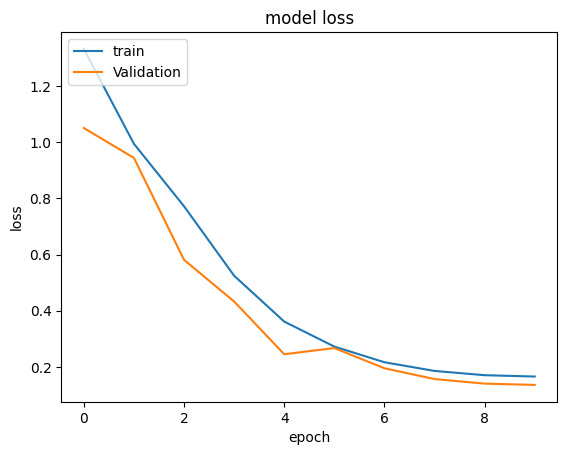

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

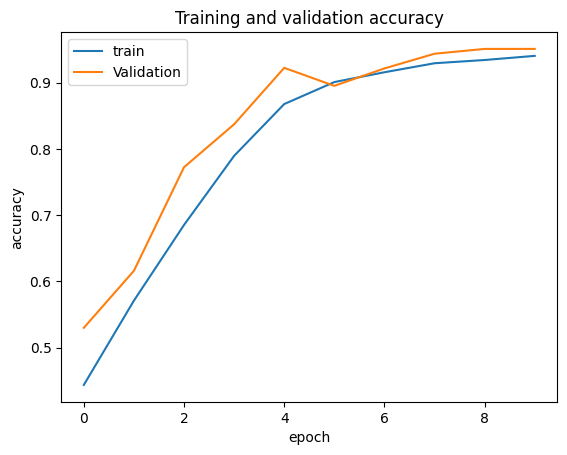

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 4s 37ms/step
[[479  12   5   0   0   0]
 [  7 421  43   0   0   0]
 [  3   0 414   1   2   0]
 [  0   3   0 389  99   0]
 [ 10   0   1  93 428   0]
 [  0  27   0   0   0 510]]
0.8961655921275874
0.8960156337356254
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       496
           1       0.91      0.89      0.90       471
           2       0.89      0.99      0.94       420
           3       0.81      0.79      0.80       491
           4       0.81      0.80      0.81       532
           5       1.00      0.95      0.97       537

    accuracy                           0.90      2947
   macro avg       0.90      0.90      0.90      2947
weighted avg       0.90      0.90      0.90      2947



<Axes: >

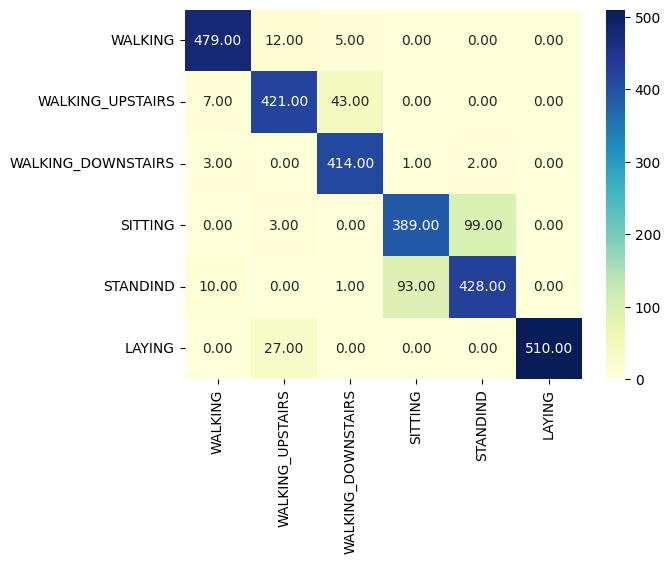

In [17]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>GRU 2</h1>


In [18]:
# Model 2
model = Sequential()
model.add(GRU(128, return_sequences=True, input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(GRU(128))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 128, 128)          53376     
                                                                 
 dropout_1 (Dropout)         (None, 128, 128)          0         
                                                                 
 gru_2 (GRU)                 (None, 128)               99072     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                                 
Total params: 169734 (663.02 KB)
Trainable params: 169

In [19]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 48s 766ms/step - loss: 1.2435 - accuracy: 0.4667 - val_loss: 1.0439 - val_accuracy: 0.5453
Epoch 2/10
58/58 [==============================] - 44s 758ms/step - loss: 0.9374 - accuracy: 0.6034 - val_loss: 0.7318 - val_accuracy: 0.6972
Epoch 3/10
58/58 [==============================] - 45s 780ms/step - loss: 0.6138 - accuracy: 0.7326 - val_loss: 0.4616 - val_accuracy: 0.8123
Epoch 4/10
58/58 [==============================] - 43s 753ms/step - loss: 0.4378 - accuracy: 0.8169 - val_loss: 0.3410 - val_accuracy: 0.8540
Epoch 5/10
58/58 [==============================] - 43s 739ms/step - loss: 0.2980 - accuracy: 0.8840 - val_loss: 0.2569 - val_accuracy: 0.9139
Epoch 6/10
58/58 [==============================] - 43s 739ms/step - loss: 0.2058 - accuracy: 0.9195 - val_loss: 0.1553 - val_accuracy: 0.9429
Epoch 7/10
58/58 [==============================] - 43s 747ms/step - loss: 0.1588 - accuracy: 0.9385 - val_loss: 0.1404 - val_accuracy: 0.9388

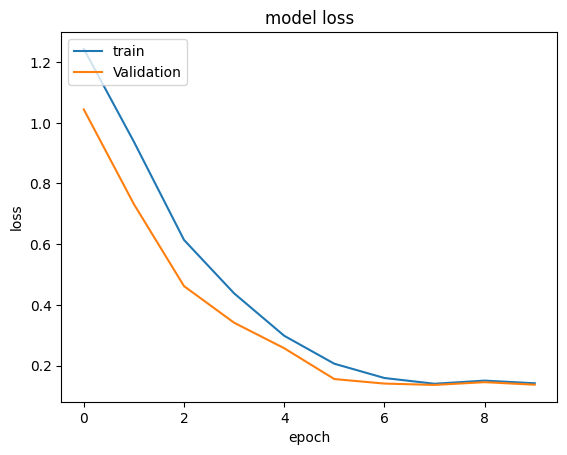

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

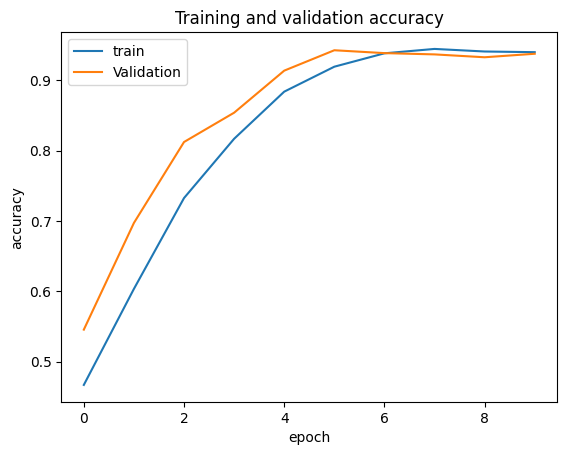

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 7s 69ms/step
[[455   6  35   0   0   0]
 [ 15 438  18   0   0   0]
 [ 12  12 396   0   0   0]
 [  1   5   0 354 131   0]
 [  7   1   0  45 479   0]
 [  0  27   0   0   0 510]]
0.8931116389548693
0.8925585023684443
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       496
           1       0.90      0.93      0.91       471
           2       0.88      0.94      0.91       420
           3       0.89      0.72      0.80       491
           4       0.79      0.90      0.84       532
           5       1.00      0.95      0.97       537

    accuracy                           0.89      2947
   macro avg       0.90      0.89      0.89      2947
weighted avg       0.90      0.89      0.89      2947



<Axes: >

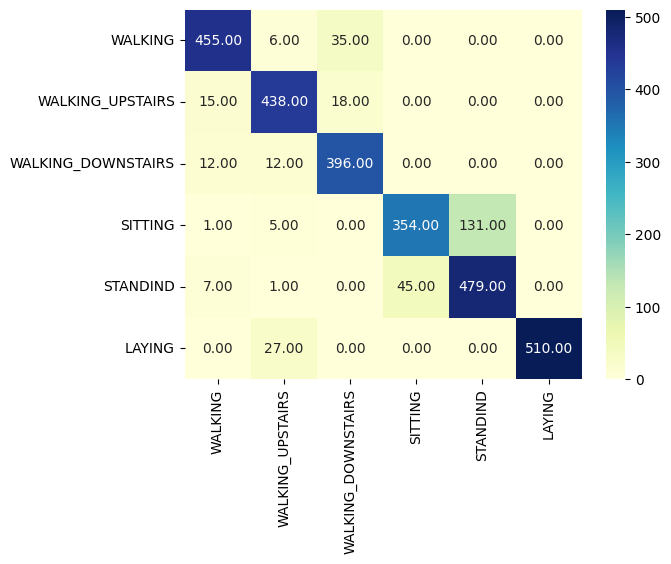

In [22]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>GRU 3</h1>


In [23]:
# Model 3
model = Sequential()
model.add(GRU(128, return_sequences=True, input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.5))

model.add(GRU(128))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 128, 128)          53376     
                                                                 
 dropout_3 (Dropout)         (None, 128, 128)          0         
                                                                 
 gru_4 (GRU)                 (None, 128, 128)          99072     
                                                                 
 dropout_4 (Dropout)         (None, 128, 128)          0         
                                                                 
 gru_5 (GRU)                 (None, 128)               99072     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 128)              

In [24]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 74s 1s/step - loss: 1.2176 - accuracy: 0.4800 - val_loss: 1.0097 - val_accuracy: 0.5558
Epoch 2/10
58/58 [==============================] - 71s 1s/step - loss: 0.9208 - accuracy: 0.6009 - val_loss: 0.7455 - val_accuracy: 0.6500
Epoch 3/10
58/58 [==============================] - 72s 1s/step - loss: 0.5593 - accuracy: 0.7465 - val_loss: 0.4043 - val_accuracy: 0.8078
Epoch 4/10
58/58 [==============================] - 72s 1s/step - loss: 0.3722 - accuracy: 0.8380 - val_loss: 0.3126 - val_accuracy: 0.8758
Epoch 5/10
58/58 [==============================] - 72s 1s/step - loss: 0.2265 - accuracy: 0.9124 - val_loss: 0.1820 - val_accuracy: 0.9402
Epoch 6/10
58/58 [==============================] - 66s 1s/step - loss: 0.1710 - accuracy: 0.9365 - val_loss: 0.1501 - val_accuracy: 0.9465
Epoch 7/10
58/58 [==============================] - 70s 1s/step - loss: 0.1618 - accuracy: 0.9355 - val_loss: 0.1517 - val_accuracy: 0.9406
Epoch 8/10
58/58 [==

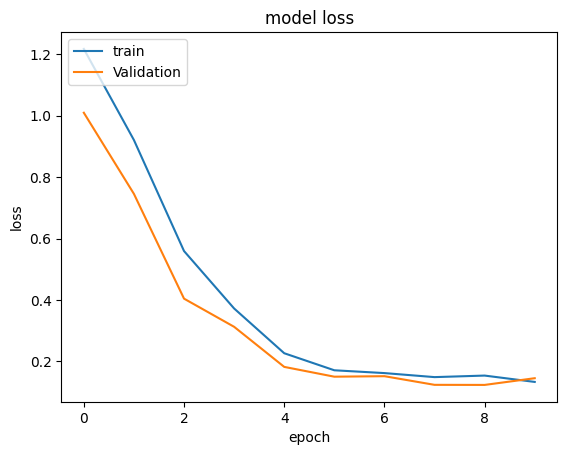

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

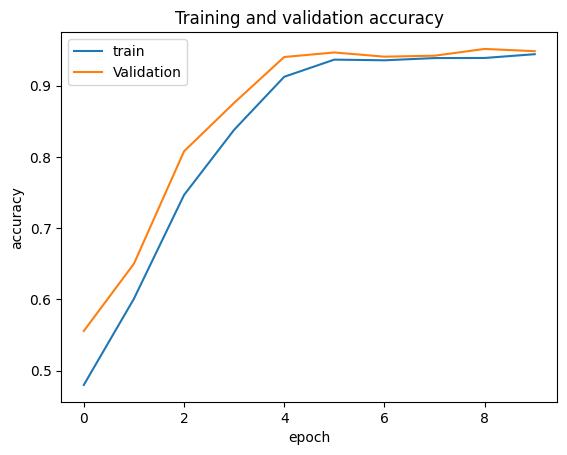

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 11s 104ms/step
[[445   0  51   0   0   0]
 [ 65 385  21   0   0   0]
 [  5   0 415   0   0   0]
 [  1   2   0 391  97   0]
 [  2   1   0 113 416   0]
 [  0  27   0   0   0 510]]
0.8693586698337292
0.8692331865373621
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       496
           1       0.93      0.82      0.87       471
           2       0.85      0.99      0.92       420
           3       0.78      0.80      0.79       491
           4       0.81      0.78      0.80       532
           5       1.00      0.95      0.97       537

    accuracy                           0.87      2947
   macro avg       0.87      0.87      0.87      2947
weighted avg       0.87      0.87      0.87      2947



<Axes: >

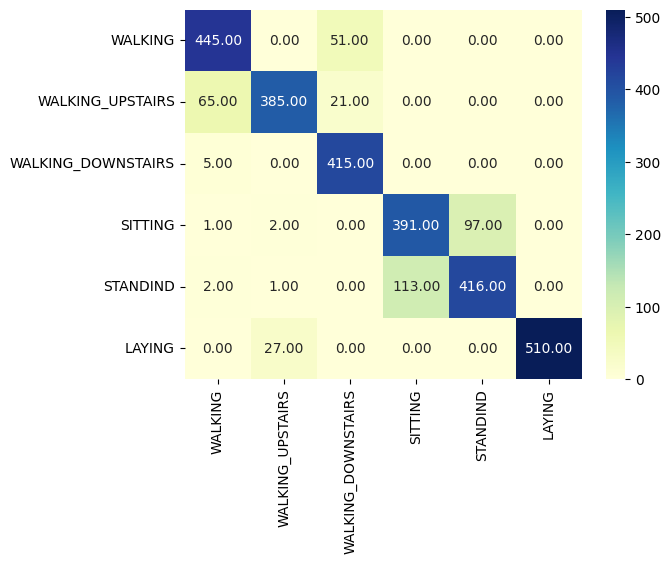

In [27]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>GRU 4</h1>

In [28]:
# Model 4
model = Sequential()
model.add(GRU(128, return_sequences=True , input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(GRU(128, return_sequences=True ))
model.add(Dropout(0.5))

model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.5))
model.add(GRU(128))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 128, 128)          53376     
                                                                 
 dropout_6 (Dropout)         (None, 128, 128)          0         
                                                                 
 gru_7 (GRU)                 (None, 128, 128)          99072     
                                                                 
 dropout_7 (Dropout)         (None, 128, 128)          0         
                                                                 
 gru_8 (GRU)                 (None, 128, 128)          99072     
                                                                 
 dropout_8 (Dropout)         (None, 128, 128)          0         
                                                                 
 gru_9 (GRU)                 (None, 128)              

In [29]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 100s 2s/step - loss: 1.2190 - accuracy: 0.4717 - val_loss: 1.0259 - val_accuracy: 0.5580
Epoch 2/10
58/58 [==============================] - 92s 2s/step - loss: 0.9549 - accuracy: 0.5911 - val_loss: 0.7190 - val_accuracy: 0.7026
Epoch 3/10
58/58 [==============================] - 93s 2s/step - loss: 0.6106 - accuracy: 0.7303 - val_loss: 0.4388 - val_accuracy: 0.7888
Epoch 4/10
58/58 [==============================] - 92s 2s/step - loss: 0.4256 - accuracy: 0.8127 - val_loss: 0.4107 - val_accuracy: 0.8214
Epoch 5/10
58/58 [==============================] - 94s 2s/step - loss: 0.3235 - accuracy: 0.8694 - val_loss: 0.2277 - val_accuracy: 0.9066
Epoch 6/10
58/58 [==============================] - 93s 2s/step - loss: 0.2200 - accuracy: 0.9162 - val_loss: 0.1737 - val_accuracy: 0.9284
Epoch 7/10
58/58 [==============================] - 93s 2s/step - loss: 0.1654 - accuracy: 0.9396 - val_loss: 0.1445 - val_accuracy: 0.9470
Epoch 8/10
58/58 [=

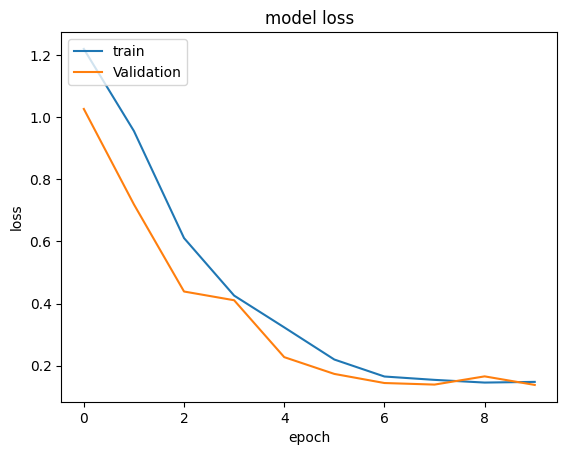

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

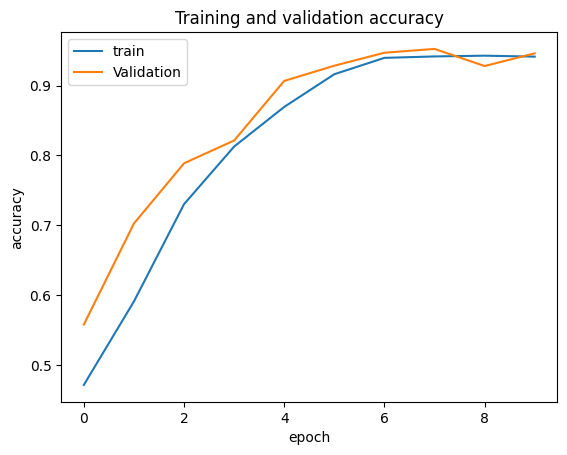

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 14s 132ms/step
[[472   1  23   0   0   0]
 [ 33 414  24   0   0   0]
 [ 18  15 387   0   0   0]
 [ 18   7   0 373  93   0]
 [  4   0   0  67 461   0]
 [  0  27   0   0   0 510]]
0.8880217170003394
0.887609085902682
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       496
           1       0.89      0.88      0.89       471
           2       0.89      0.92      0.91       420
           3       0.85      0.76      0.80       491
           4       0.83      0.87      0.85       532
           5       1.00      0.95      0.97       537

    accuracy                           0.89      2947
   macro avg       0.89      0.89      0.89      2947
weighted avg       0.89      0.89      0.89      2947



<Axes: >

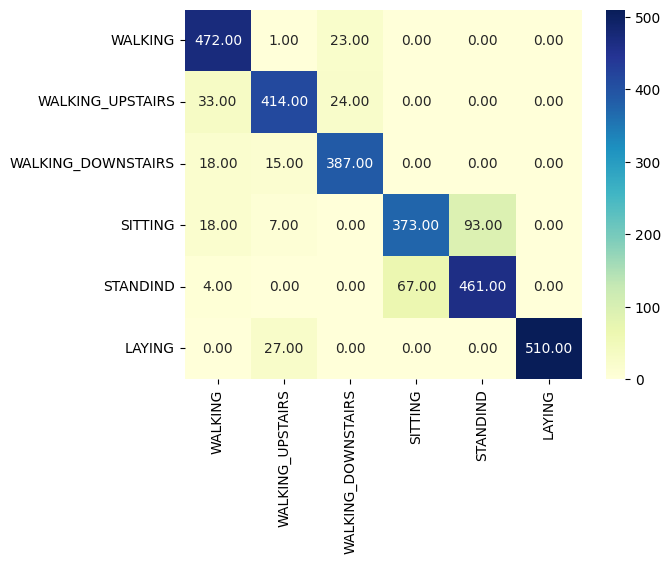

In [32]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')

<h1>GRU 5</h1>

In [33]:
# Model 1
model = Sequential()
model.add(GRU(128, return_sequences=True , input_shape=(n_timesteps, n_features)))
model.add(Dropout(0.5))

model.add(GRU(128, return_sequences=True ))
model.add(Dropout(0.5))

model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.5))

model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.5))

model.add(GRU(128))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))

model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_10 (GRU)                (None, 128, 128)          53376     
                                                                 
 dropout_10 (Dropout)        (None, 128, 128)          0         
                                                                 
 gru_11 (GRU)                (None, 128, 128)          99072     
                                                                 
 dropout_11 (Dropout)        (None, 128, 128)          0         
                                                                 
 gru_12 (GRU)                (None, 128, 128)          99072     
                                                                 
 dropout_12 (Dropout)        (None, 128, 128)          0         
                                                                 
 gru_13 (GRU)                (None, 128, 128)         

In [34]:
# validation_split = 0.1
batch_size = 128

train_epochs = 10
history = model.fit(trainX, trainy_one_hot, epochs=train_epochs, batch_size=batch_size, verbose=True,  validation_data = (X_val, y_val_one_hot), shuffle=True)

Epoch 1/10
58/58 [==============================] - 138s 2s/step - loss: 1.1749 - accuracy: 0.4875 - val_loss: 1.0038 - val_accuracy: 0.5730
Epoch 2/10
58/58 [==============================] - 125s 2s/step - loss: 0.9212 - accuracy: 0.6000 - val_loss: 0.6870 - val_accuracy: 0.6963
Epoch 3/10
58/58 [==============================] - 125s 2s/step - loss: 0.5404 - accuracy: 0.7617 - val_loss: 0.4899 - val_accuracy: 0.7983
Epoch 4/10
58/58 [==============================] - 126s 2s/step - loss: 0.3826 - accuracy: 0.8466 - val_loss: 0.2340 - val_accuracy: 0.9098
Epoch 5/10
58/58 [==============================] - 118s 2s/step - loss: 0.2181 - accuracy: 0.9191 - val_loss: 0.2597 - val_accuracy: 0.9102
Epoch 6/10
58/58 [==============================] - 120s 2s/step - loss: 0.1850 - accuracy: 0.9300 - val_loss: 0.1536 - val_accuracy: 0.9424
Epoch 7/10
58/58 [==============================] - 129s 2s/step - loss: 0.1690 - accuracy: 0.9362 - val_loss: 0.1461 - val_accuracy: 0.9529
Epoch 8/10
58

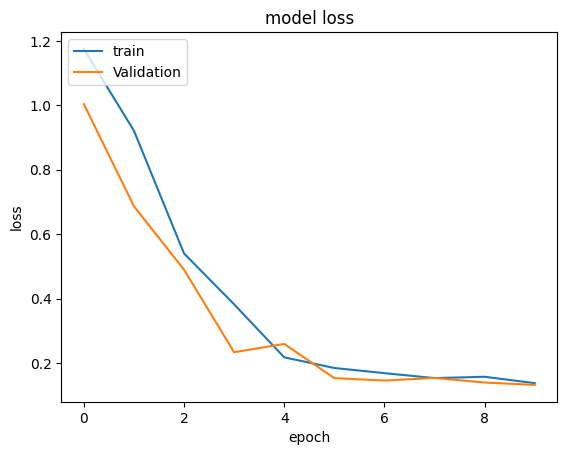

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

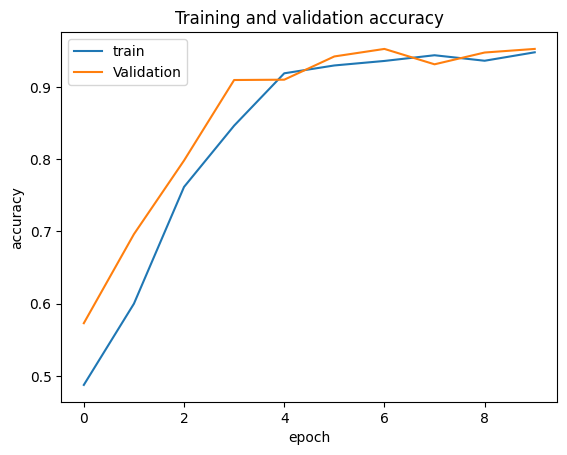

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')

93/93 [==============================] - 17s 166ms/step
[[454  12  30   0   0   0]
 [ 17 417  37   0   0   0]
 [  1   0 419   0   0   0]
 [  8  18   0 417  48   0]
 [ 12   0   0 130 390   0]
 [  0  27   0   0   0 510]]
0.8846284356973193
0.8840989601014554
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       496
           1       0.88      0.89      0.88       471
           2       0.86      1.00      0.92       420
           3       0.76      0.85      0.80       491
           4       0.89      0.73      0.80       532
           5       1.00      0.95      0.97       537

    accuracy                           0.88      2947
   macro avg       0.89      0.89      0.88      2947
weighted avg       0.89      0.88      0.88      2947



<Axes: >

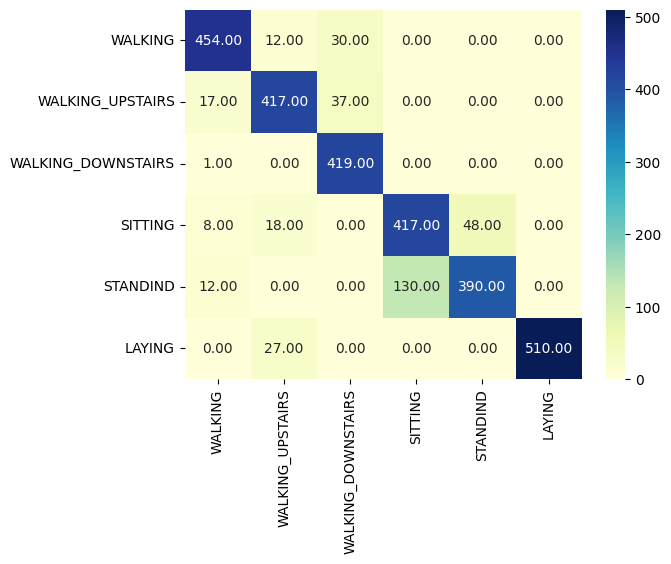

In [37]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

predy=model.predict(testX)
predy=np.argmax(predy, axis=-1)
LABELS = ['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS', 'SITTING','STANDIND','LAYING']
cm=confusion_matrix(testy,predy)
print(cm)
print(accuracy_score(testy,predy))
print(f1_score(testy,predy, average='weighted'))
print(classification_report(testy,predy))
sns.heatmap(cm, cmap="YlGnBu", xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt = '.2f')